table of contents  
1. Prepare  
2. Read Dataset, and Preprocess  
3. Possesion / Non Possesion

# Prepare

## Import Library
please pull this [repo](https://github.com/saeeeeru/AutoFomationDetector)

In [1]:
import os, time, sys
from datetime import datetime, date
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10')
%matplotlib inline

# import Metrica Utilities
sys.path.append(os.path.join('..','src'))
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel

# import AutoFormation Detector
sys.path.append(os.path.join('..','..','..','football-analysis','AutoFormationDetector','src'))
from main import AutoFormationDetector

## Setting static parameter

In [2]:
base_dir = os.path.join('..')
data_dir = os.path.join(base_dir, '..', 'sample-data', 'data')

game_id = 2

# Read Dataset, and Preprocess

In [3]:
# Read Daset
events_df = mio.read_event_data(data_dir, game_id)
tracking_home_df = mio.tracking_data(data_dir, game_id, 'Home')
tracking_away_df = mio.tracking_data(data_dir, game_id, 'Away')

# convert positions
events_df = mio.to_metric_coordinates(events_df)
tracking_home_df = mio.to_metric_coordinates(tracking_home_df)
tracking_away_df = mio.to_metric_coordinates(tracking_away_df)

# rebase direction
tracking_home_df, tracking_away_df, events_df = mio.to_single_playing_direction(tracking_home_df, tracking_away_df, events_df)

# calculate player Velocities
# tracking_home_df = mvel.calc_player_velocities(tracking_home_df, smoothing=True, filter_='moving average')
# tracking_away_df = mvel.calc_player_velocities(tracking_away_df, smoothing=True, filter_='moving average')

Reading team: home
Reading team: away


# Possession, Non Possession

## check events_df

In [4]:
events_df.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44


In [5]:
events_df.Type.unique()

array(['SET PIECE', 'PASS', 'BALL LOST', 'CHALLENGE', 'RECOVERY',
       'BALL OUT', 'SHOT', 'FAULT RECEIVED', 'CARD'], dtype=object)

## get possession

In [6]:
c_list = ['Period', 'Team', 'Start Time [s]', 'End Time [s]']

In [7]:
posession_list = []

for period in events_df.Period.unique():
    events_df_tmp = events_df[events_df.Period==period]
    
    team, st, ed = events_df_tmp.groupby('Period').agg({'Team':'first', 'Start Time [s]':'first', 'End Time [s]':'last'}).values[0,:]
    
    flg_array = events_df_tmp.Team.values[:-1] != events_df_tmp.Team.values[1:]
    events_df_only_transition = events_df_tmp[events_df_tmp.index.isin(events_df_tmp.index.values[1:][flg_array])]

    index_last = events_df_only_transition.index.values[-1]

    for i in events_df_only_transition.index:
        team_, st_ = events_df_only_transition.loc[i, c_list[1:-1]]

        if i == index_last:
            posession = [period, team_, st_, ed]
        else:
            posession  = [period, team, st, st_]

        # append
        posession_list.append(posession)

        # update
        team, st = team_, st_

# make df
possession_df = pd.DataFrame(data=posession_list, columns=c_list)

## visualize

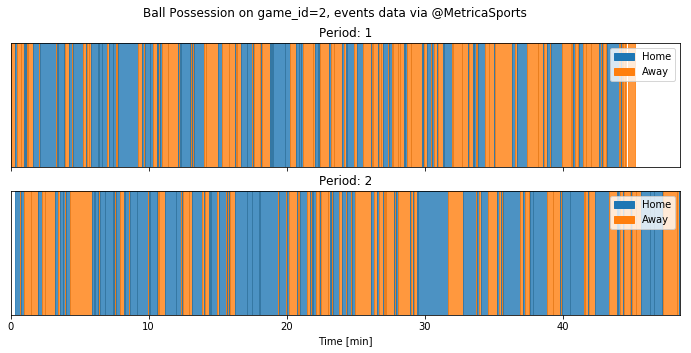

In [8]:
import matplotlib.patches as patches

color_dict = {'Home':cmap(0), 'Away': cmap(1)}

n_period = len(events_df.Period.unique())
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 2.5*n_period), sharex=True)

for period in events_df.Period.unique():
    ax = axes[period-1]
    possession_df_tmp = possession_df[possession_df.Period==period]
    for i in possession_df_tmp.index:
        team, st_s, ed_s = possession_df_tmp.loc[i, c_list[1:]]
        st_m, ed_m = (st_s/60., ed_s/60.) if period==1 else (st_s/60-45, ed_s/60-45)
        rect = patches.Rectangle((st_m,0), width=ed_m-st_m, height=1, color=color_dict[team], alpha=0.8)
        ax.add_patch(rect)

    ax.get_yaxis().set_visible(False)
    ax.set_xlim([0, ed_m])
    ax.set_title(f'Period: {period}')

    ax.legend(handles=[patches.Patch(color=c, label=l) for l, c in color_dict.items()])

ax.set_xlabel('Time [min]')
fig.suptitle(f'Ball Possession on game_id={game_id}, events data via @MetricaSports')

plt.savefig(os.path.join(base_dir, 'reports', 'figure', f'posession-game_id={game_id}.png'), bbox_inches='tight')

## split tracking_df based on possession_df

In [9]:
def replace_value_to_nan(data_array, index_array):
    for i, d in enumerate(index_array.sum(axis=1)):
        if d!=2*11:
            data_array[i, np.nonzero(np.isnan(data_array[i+1]))] = np.nan

    return data_array

In [10]:
data_dict = {f'game_id={game_id}_Home_on':[], f'game_id={game_id}_Home_off':[], f'game_id={game_id}_Away_on':[], f'game_id={game_id}_Away_off':[]}

c = 'Time [s]'
n_player = 10

for i, (team, st, ed) in tqdm(possession_df.iloc[:,1:].iterrows()):
    tracking_home_array = tracking_home_df[(st <= tracking_home_df[c])&(tracking_home_df[c] < ed)&(tracking_home_df[c].apply(lambda x: f'{x: .2f}').str.contains('.00'))].iloc[:,4:-2].values
    index_home_array = ~np.isnan(tracking_home_array)
    if len(tracking_home_array[index_home_array]) % (n_player*2) == 0:
        tracking_home_list = tracking_home_array[index_home_array].reshape(-1,n_player*2).tolist()
    else:
        tracking_home_array = replace_value_to_nan(tracking_home_array, index_home_array)
        tracking_home_list = tracking_home_array[~np.isnan(tracking_home_array)].reshape(-1,n_player*2).tolist()

    tracking_away_array = tracking_away_df[(st <= tracking_away_df[c])&(tracking_away_df[c] < ed)&(tracking_away_df[c].apply(lambda x: f'{x: .2f}').str.contains('.00'))].iloc[:,4:-2].values
    index_away_array = ~np.isnan(tracking_away_array)
    if len(tracking_away_array[index_away_array]) % (n_player*2) == 0:
        tracking_away_list = tracking_away_array[index_away_array].reshape(-1,n_player*2).tolist()
    else:
        tracking_away_array = replace_value_to_nan(tracking_away_array, index_away_array)
        tracking_away_list = tracking_away_array[~np.isnan(tracking_away_array)].reshape(-1,n_player*2).tolist()


    if team == 'Home': 
        data_dict[f'game_id={game_id}_Home_on'] += tracking_home_list
        data_dict[f'game_id={game_id}_Away_off'] += tracking_away_list
    else:
        data_dict[f'game_id={game_id}_Away_on'] += tracking_away_list
        data_dict[f'game_id={game_id}_Home_off'] += tracking_home_list

502it [04:23,  1.91it/s]


In [11]:
from scipy.stats import zscore
for k, data_list in data_dict.items():
        data_dict[k] = np.array([zscore(data) for data in np.array(data_list).reshape(-1,n_player,2)])

In [12]:
params_dict = {
    'fig_dir':os.path.join(base_dir,'reports','figure','AutoFormationDetector'),
    'mesh_size':.01,
    'n_iterations':10
}
auto_formation_detector = AutoFormationDetector(params_dict, data_dict)

In [13]:
auto_formation_detector.rv_dict = {}
for n, (key, data_array) in enumerate(auto_formation_detector.data_dict.items()):
    print(f'optimize -> {key} ({n+1}/{len(auto_formation_detector.data_dict)})')
    
    rv_list = auto_formation_detector.optimize_role_distribution(data_array, key)
    auto_formation_detector.rv_dict[key] = rv_list

optimize -> game_id=2_Home_on (1/4)
4161it [00:38, 107.40it/s]
8it [00:00, 77.94it/s]diff of V at iteration 0: 0.1839207189695637 (39.56108999252319 [sec])
3255it [00:47, 33.39it/s]

KeyboardInterrupt: 